In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

병원 폐업 여부 예측 모델을 개발하는 것이 목표 !! 

train.csv - 의료기관이 폐업했는지 여부를 포함하여 최근 2개년의 재무정보와 병원 기본정보 

test.csv - 폐업 여부를 제외하고 train.csv와 동일 

sample_submission.csv - inst_id와 open과 close를 예측하는 OC 두개의 열로 구성. OC의 값은 open 예측일 경우 1, close 예측일 경우 0.




inst_id - 각 파일에서의 병원 고유 번호

OC – 영업/폐업 분류, 2018년 폐업은 2017년 폐업으로 간주함

sido – 병원의 광역 지역 정보

sgg – 병원의 시군구 자료

openDate – 병원 설립일

bedCount - 병원이 갖추고 있는 병상의 수

instkind – 병원, 의원, 요양병원, 한의원, 종합병원 등 병원의 종류

·        종합병원 : 입원환자 100명 이상 수용 가능

·        병원 : 입원 환자 30명 이상 100명 미만 수용 가능

·        의원 : 입원 환자 30명 이하 수용 가능

·        한방 병원(한의원) : 침술과 한약으로 치료하는 의료 기관.  

 
+ 이외로 데이터 추가적으로 더 있음 
(년도별 부채총계, 유동부채, 단기차입금 등 ) - 여기서 좀 어려운 부분 ...(?)


폐업은 0, 잔존은 1로 예측 

각 항목 뒤 숫자가 1이면 2017년 데이터
각 항목 뒤 숫자가 2이면 2016년 데이터

2016 25개 2017 25개 공통 8개

## train 파일

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [6]:
train

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,open,jeonnam,178,20050211,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7.086391e+06,1.191266e+10,1.171868e+10,1.198567e+08,0.0,8.715369e+09,1.520004e+09,0.000

열이 58개로 적지는 않은 듯함 ... 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

In [7]:
train.isnull().sum()

inst_id                0
OC                     0
sido                   0
sgg                    0
openDate               0
bedCount               5
instkind               1
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
profit1                8
liquidAsset1           8
quickAsset1            8
receivableS1           8
inventoryAsset1        8
nonCAsset1             8
tanAsset1              8
OnonCAsset1            8
receivableL1           8
debt1                  8
liquidLiabilities1     8
shortLoan1             8
NCLiabilities1         8
longLoan1              8
netAsset1              8
surplus1               8
revenue2               8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8


결측치를 확인해보니 2016년과 2017년 공통으로 가지고 있는 행은 2개씩 있음

물론 이외의 다른 데이터들에도 결측치 존재

In [10]:
train.dtypes

inst_id                 int64
OC                     object
sido                   object
sgg                     int64
openDate                int64
bedCount              float64
instkind               object
revenue1              float64
salescost1            float64
sga1                  float64
salary1               float64
noi1                  float64
noe1                  float64
interest1             float64
ctax1                 float64
profit1               float64
liquidAsset1          float64
quickAsset1           float64
receivableS1          float64
inventoryAsset1       float64
nonCAsset1            float64
tanAsset1             float64
OnonCAsset1           float64
receivableL1          float64
debt1                 float64
liquidLiabilities1    float64
shortLoan1            float64
NCLiabilities1        float64
longLoan1             float64
netAsset1             float64
surplus1              float64
revenue2              float64
salescost2            float64
sga2      

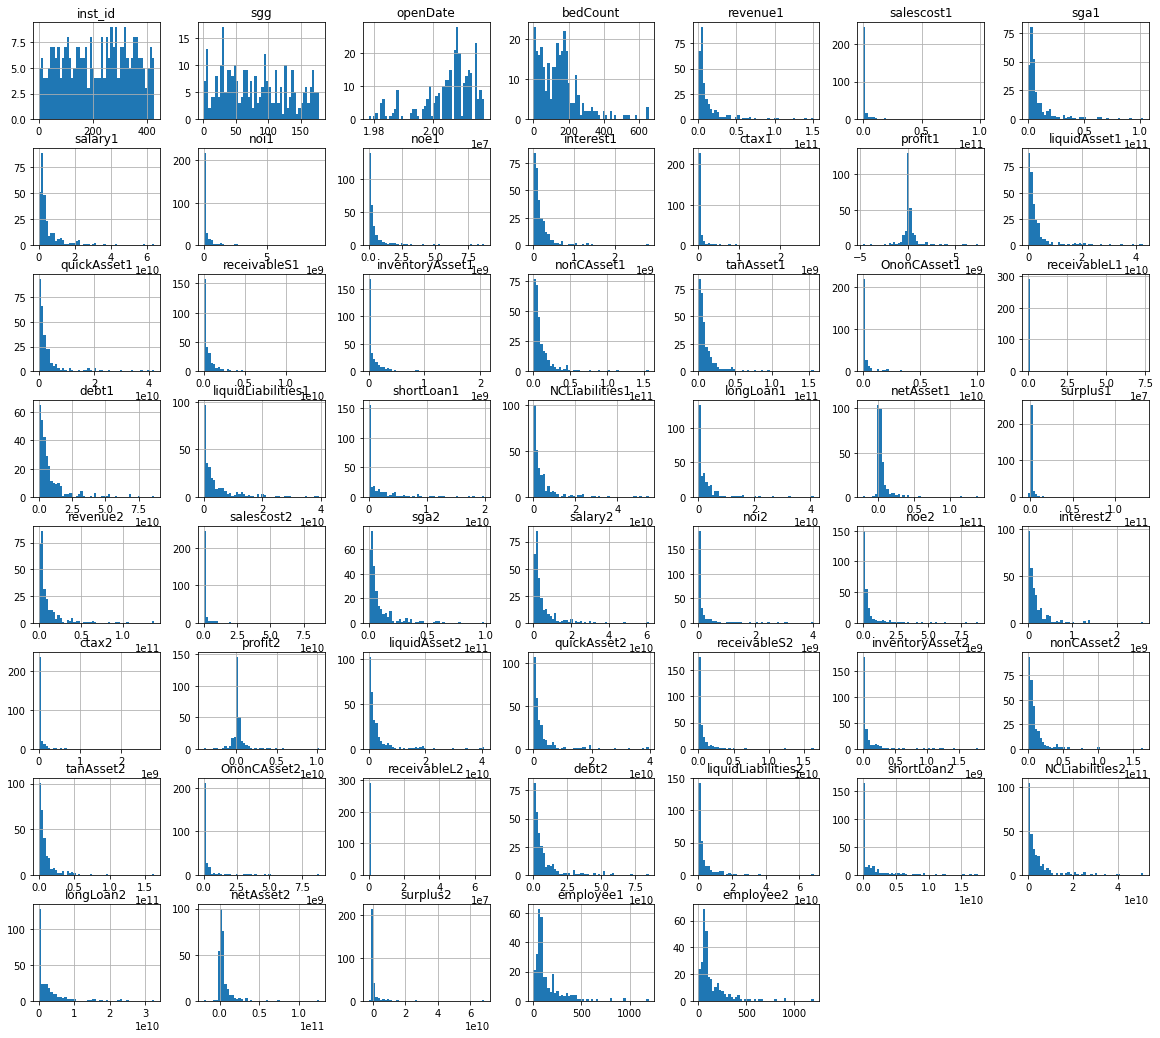

In [8]:
_=train.hist(bins=50,figsize=(20,18))

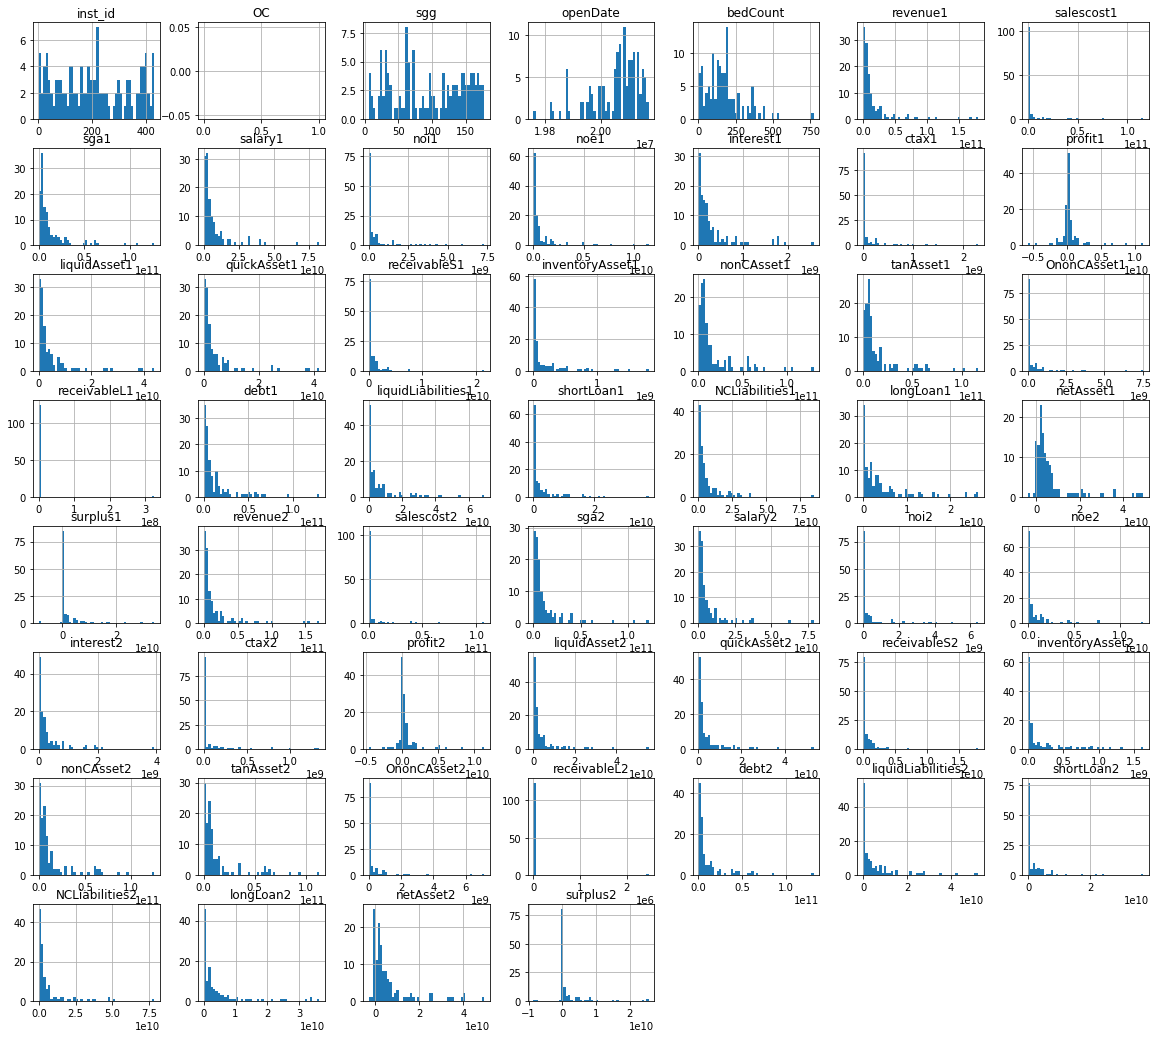

In [3]:
_=test.hist(bins=50,figsize=(20,18))

In [11]:
train.isnull().sum().sort_values(ascending=False)

employee2             13
ownerChange           12
employee1             10
inventoryAsset2        8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8
liquidAsset2           8
quickAsset2            8
receivableS2           8
nonCAsset2             8
surplus1               8
tanAsset2              8
OnonCAsset2            8
receivableL2           8
debt2                  8
liquidLiabilities2     8
shortLoan2             8
NCLiabilities2         8
longLoan2              8
netAsset2              8
surplus2               8
revenue2               8
netAsset1              8
profit1                8
quickAsset1            8
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
longLoan1              8


결측치 확인

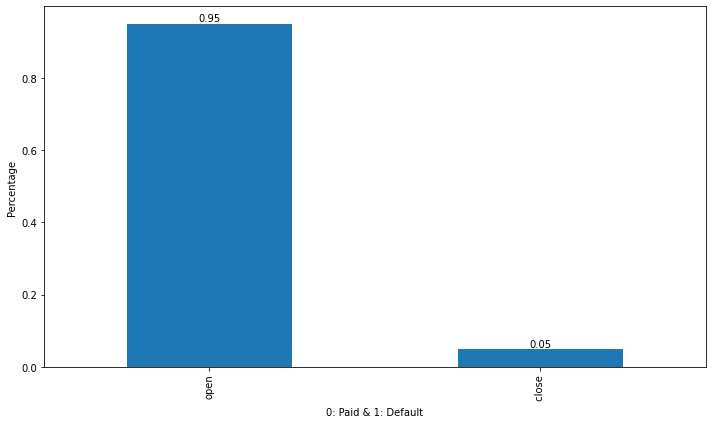

In [12]:
target = train["OC"].value_counts()/len(train)

ax = target.plot(kind="bar", figsize=[10,6])

ax.bar_label(ax.containers[0], fmt="%.2f")
ax.set_xlabel("0: Paid & 1: Default")
ax.set_ylabel("Percentage")

plt.tight_layout()
plt.show()

폐업과 잔존의 비율이 약 95:5

KeyError: 0

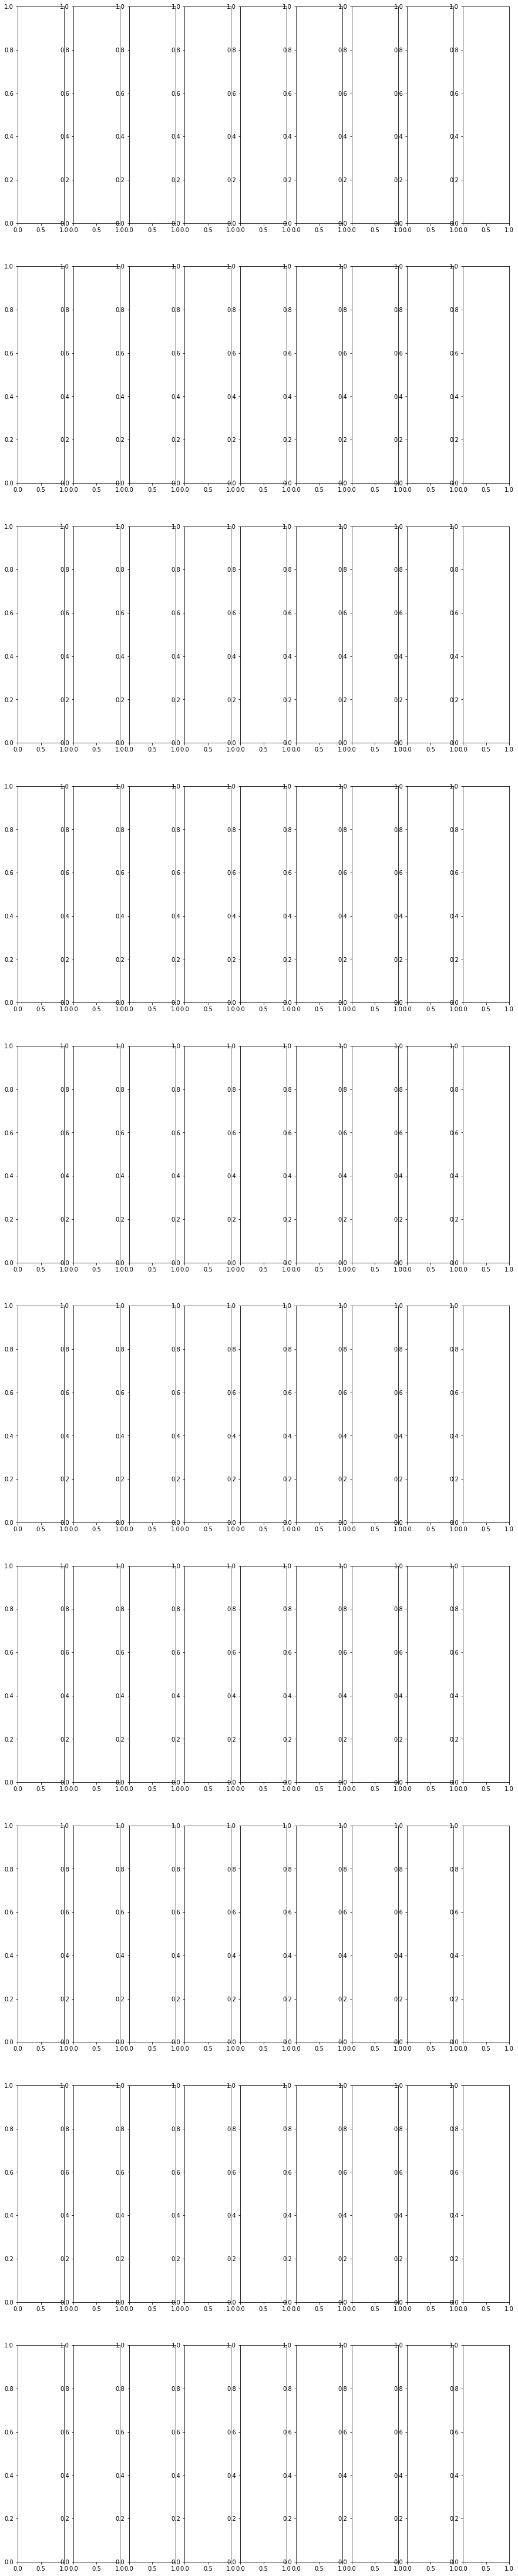

In [15]:
fig, axes = plt.subplots(nrows=10, ncols=9, figsize=(15,80))

for i in range(10):
    for j in range(9):
        train.boxplot(column=train[i][j], by="OC", ax=axes[i][j])
        
for ax in axes:
    ax.set_xlabel("OC")
    
plt.suptitle('')
plt.tight_layout()

plt.show()

이상치 확인하려고 했는데 ????

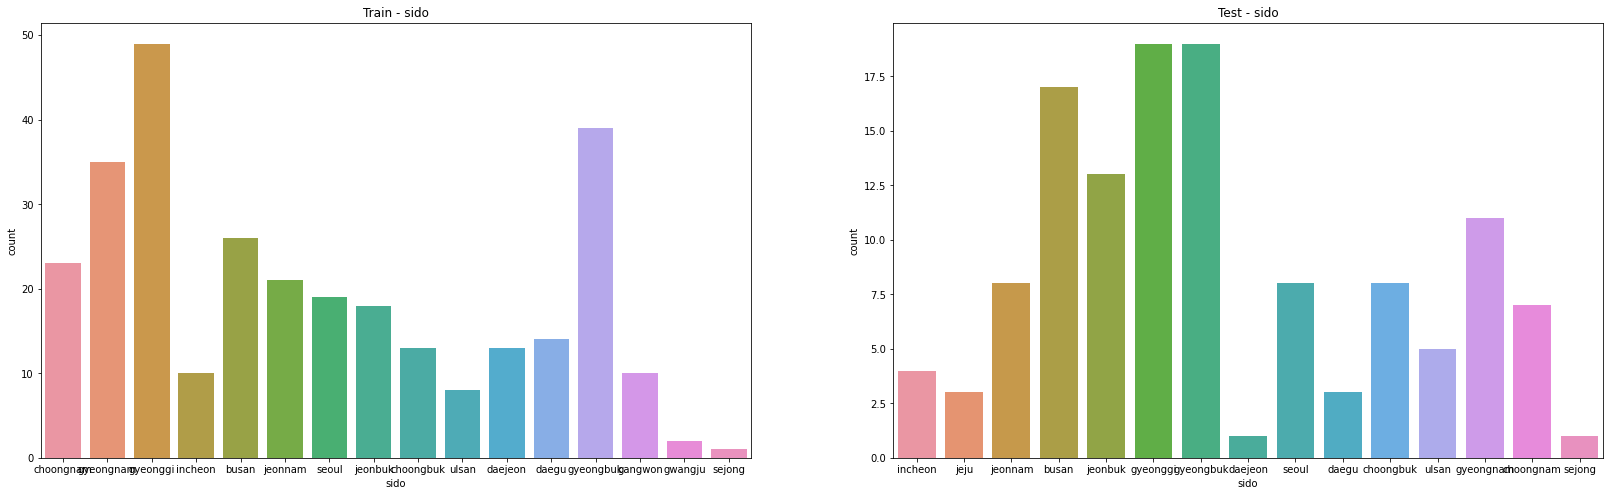

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.countplot(data=train, x="sido", ax=ax[0]).set_title("Train - sido")
sns.countplot(data=test, x="sido", ax=ax[1]).set_title("Test - sido")
plt.show()

countplot은 각 항목의 데이터 개수를 카운트  해주는 것 ㅇㅇ


In [ ]:
ownerchange.....도

## train 파일

In [10]:
train=pd.read_csv("train.csv")

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [12]:
train.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,225169678.0,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.0,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,207829685.0,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,41864754.0,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,902830288.0,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.0,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,838387466.0,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,80749696.0,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.0,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,32642585.0,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [ ]:
test 데이터와 폐업 여부를 제외하고 train데이터와 동일함